In [1]:
import neurogym as ngym
import gymnasium as gym

# TODO: plot the task, no training
# TODO: train with SL and RL
# TODO: plot the trained agent
# TODO: add some context for Mante task
# TODO: remove perf plot

task = "UnifiedContextDecisionMaking"
env = gym.make(task)
# # check the custom environment and output additional warnings (if any)
# check_env(env)

# check the environment with a random agent
obs, info = env.reset()
n_steps = 10
for _ in range(n_steps):
    # random action
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated:
        obs, info = env.reset()

print("----------------")
print(env.timing)
print("----------------")
print(env.observation_space)
print(env.observation_space.name)
print("----------------")
print(env.action_space)
print(env.action_space.name)

----------------
{'fixation': 300, 'stimulus': 750, 'delay': <neurogym.utils.ngym_random.TruncExp object at 0x1274103d0>, 'decision': 100}
----------------
Box(-inf, inf, (5,), float32)
{'fixation': 0, 'stimulus1_mod1': 1, 'stimulus2_mod1': 2, 'stimulus1_mod2': 3, 'stimulus2_mod2': 4}
----------------
Discrete(3)
{'fixation': 0, 'choice': range(1, 3)}


/Users/giuliacrocioni/miniforge3/envs/neurogym/lib/python3.11/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `UnifiedContextDecisionMaking-v0` instead of the unversioned environment `UnifiedContextDecisionMaking`.
  logger.warn(
/Users/giuliacrocioni/miniforge3/envs/neurogym/lib/python3.11/site-packages/gymnasium/envs/registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['paper_link', 'paper_name', 'tags']
  logger.warn(
/Users/giuliacrocioni/miniforge3/envs/neurogym/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.timing to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.timing` for environment variables or `env.get_wrapper_attr('timing')` that will search the reminding wrappers.
  logger.warn(


/Users/giuliacrocioni/miniforge3/envs/neurogym/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.rewards to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.rewards` for environment variables or `env.get_wrapper_attr('rewards')` that will search the reminding wrappers.
  logger.warn(


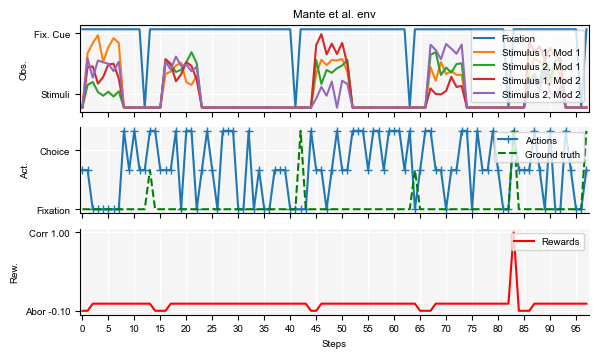

In [2]:
fig = ngym.utils.plot_env(
    env,
    name='Mante et al.',
    ob_traces=['Fixation', 'Stimulus 1, Mod 1', 'Stimulus 2, Mod 1', 'Stimulus 1, Mod 2', 'Stimulus 2, Mod 2'],
    num_trials=5,
    plot_performance=False,
)

In [ ]:
import warnings

from stable_baselines3 import A2C
from neurogym.wrappers import monitor, TrialHistoryV2
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np

warnings.filterwarnings("default")

# task paremters
# TODO: are we fine with the defaults? If yes, delete this block
# use the default values but explain and show how to change them
timing = {
    "fixation": ("constant", 300),
    "stimulus": ("constant", 700),
    "decision": ("constant", 300),
}
kwargs = {"dt": 100, "timing": timing}
# wrapper parameters
n_ch = 2
p = 0.8
num_blocks = 2
probs = np.array([[p, 1 - p], [1 - p, p]])  # repeating block

# train agent
task = "UnifiedContextDecisionMaking"
env = gym.make(task, **kwargs)
# Apply the wrapper
# TODO: scope of the wrapper?
# We don't want it for the Mante task, it is introducing correlations between the trials
env = TrialHistoryV2(env, probs=probs)
# we will need Trial History for the IBL task later
# TODO: folder functionality is broken, if folder is not none it gives error (see demo.ioynb as well)
env = monitor.Monitor(env, sv_per=10000, verbose=1, sv_fig=True, num_stps_sv_fig=100)
env_vec = DummyVecEnv([lambda: env])
model = A2C("MlpPolicy", env_vec, verbose=1)
model.learn(total_timesteps=20000, log_interval=1000)
env_vec.close()

# plot example trials with trained agent
fig = ngym.utils.plot_env(
    env,
    ob_traces=["fixation", "stimulus_mod1", "stimulus_mod2", "decision", "choice"],
    num_trials=5,
    model=model,
)

/Users/giuliacrocioni/miniforge3/envs/neurogym/lib/python3.11/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `SingleContextDecisionMaking-v0` instead of the unversioned environment `SingleContextDecisionMaking`.
  logger.warn(
/Users/giuliacrocioni/miniforge3/envs/neurogym/lib/python3.11/site-packages/gymnasium/envs/registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['paper_link', 'paper_name', 'tags']
  logger.warn(
/Users/giuliacrocioni/miniforge3/envs/neurogym/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.choices to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.choices` for environment variables or `env.get_wrapper_attr('choices')` that will search the reminding wrappers.
  logger.warn(
/Users/giuliacrocioni/miniforge3/envs/neurogym/lib/python3.11/site-pa

Using cpu device


/Users/giuliacrocioni/miniforge3/envs/neurogym/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.rng to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.rng` for environment variables or `env.get_wrapper_attr('rng')` that will search the reminding wrappers.
  logger.warn(
/Users/giuliacrocioni/miniforge3/envs/neurogym/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.choices to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.choices` for environment variables or `env.get_wrapper_attr('choices')` that will search the reminding wrappers.
  logger.warn(
/Users/giuliacrocioni/miniforge3/envs/neurogym/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.new_trial to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can d

--------------------------------------
| time/                 |            |
|    fps                | 1805       |
|    iterations         | 1000       |
|    time_elapsed       | 2          |
|    total_timesteps    | 5000       |
| train/                |            |
|    entropy_loss       | -0.318     |
|    explained_variance | -33.550632 |
|    learning_rate      | 0.0007     |
|    n_updates          | 999        |
|    policy_loss        | -0.0345    |
|    value_loss         | 0.0134     |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 1885      |
|    iterations         | 2000      |
|    time_elapsed       | 5         |
|    total_timesteps    | 10000     |
| train/                |           |
|    entropy_loss       | -0.1      |
|    explained_variance | 0.0       |
|    learning_rate      | 0.0007    |
|    n_updates          | 1999      |
|    policy_loss        | -0.000507 

NameError: name 'ngym' is not defined